# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
# silence NumbaPerformanceWarning
import warnings
from numba.errors import NumbaPerformanceWarning
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.2 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


# Load FBM DC lineages

In [3]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/bm_plus_19pcw/data/bm_plus_19pcw_raw_dr_20200414.h5ad')

In [4]:
adata.raw = adata

In [5]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CAR                          365
CD4 T                        327
CD8 T                        171
CD14 monocyte               8787
CD56 bright NK               540
CMP                          425
DC1                           50
DC2                          598
DC3                          705
DC precursor                 201
ELP                         1358
GMP                         1285
HSC                           92
ILC precursor                 67
Immature B cell             1998
MEMP                          16
MEP                          269
MK                          1036
MPP lymphoid                  34
MPP myeloid 1                 46
MPP myeloid 2                 46
NKT                          137
Naive B cell                1423
Pre B progenitor           14234
Pre pro B progenitor        5428
Pro B progenitor            5530
Treg                          62
basophil                     139
chondrocyte                   72
chondrocyte precursor        16

In [6]:
myeloid_celltypes = ['HSC', 'MPP myeloid 1', 'MPP myeloid 2', 'MPP lymphoid', 'ELP', 'pDC progenitor', 'pDC', 'tDC', 'myeloid DC progenitor', 'DC precursor', 'DC1', 'DC2', 'DC3']

In [7]:
adata = adata[adata.obs['cell.labels'].isin(myeloid_celltypes)].copy()

In [8]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
DC1                        50
DC2                       598
DC3                       705
DC precursor              201
ELP                      1358
HSC                        92
MPP lymphoid               34
MPP myeloid 1              46
MPP myeloid 2              46
myeloid DC progenitor      31
pDC                       713
pDC progenitor             23
tDC                       193
dtype: int64

In [9]:
adata.shape

(4090, 33712)

# Pre-process the dataset

In [10]:
# normalise count data 
sc.pp.normalize_total(adata)

In [11]:
# log the count data 
sc.pp.log1p(adata)

In [12]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [13]:
# scale the data 
sc.pp.scale(adata, max_value=10)

In [14]:
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

In [15]:
# run pca
sc.tl.pca(adata, n_comps=50)

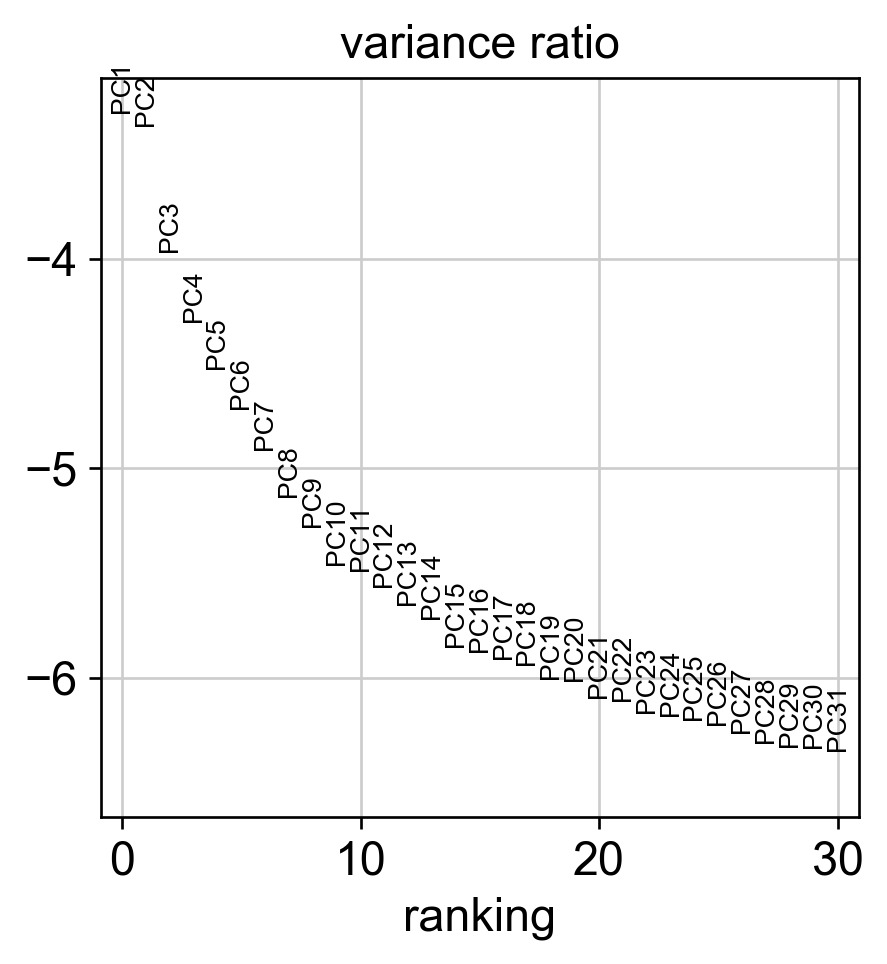

In [16]:
# have a look at pc's in order to choose number of pcs that will be used downstream 
sc.pl.pca_variance_ratio(adata, log=True)

In [17]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=10) 

In [18]:
# run umap
sc.tl.umap(adata) 

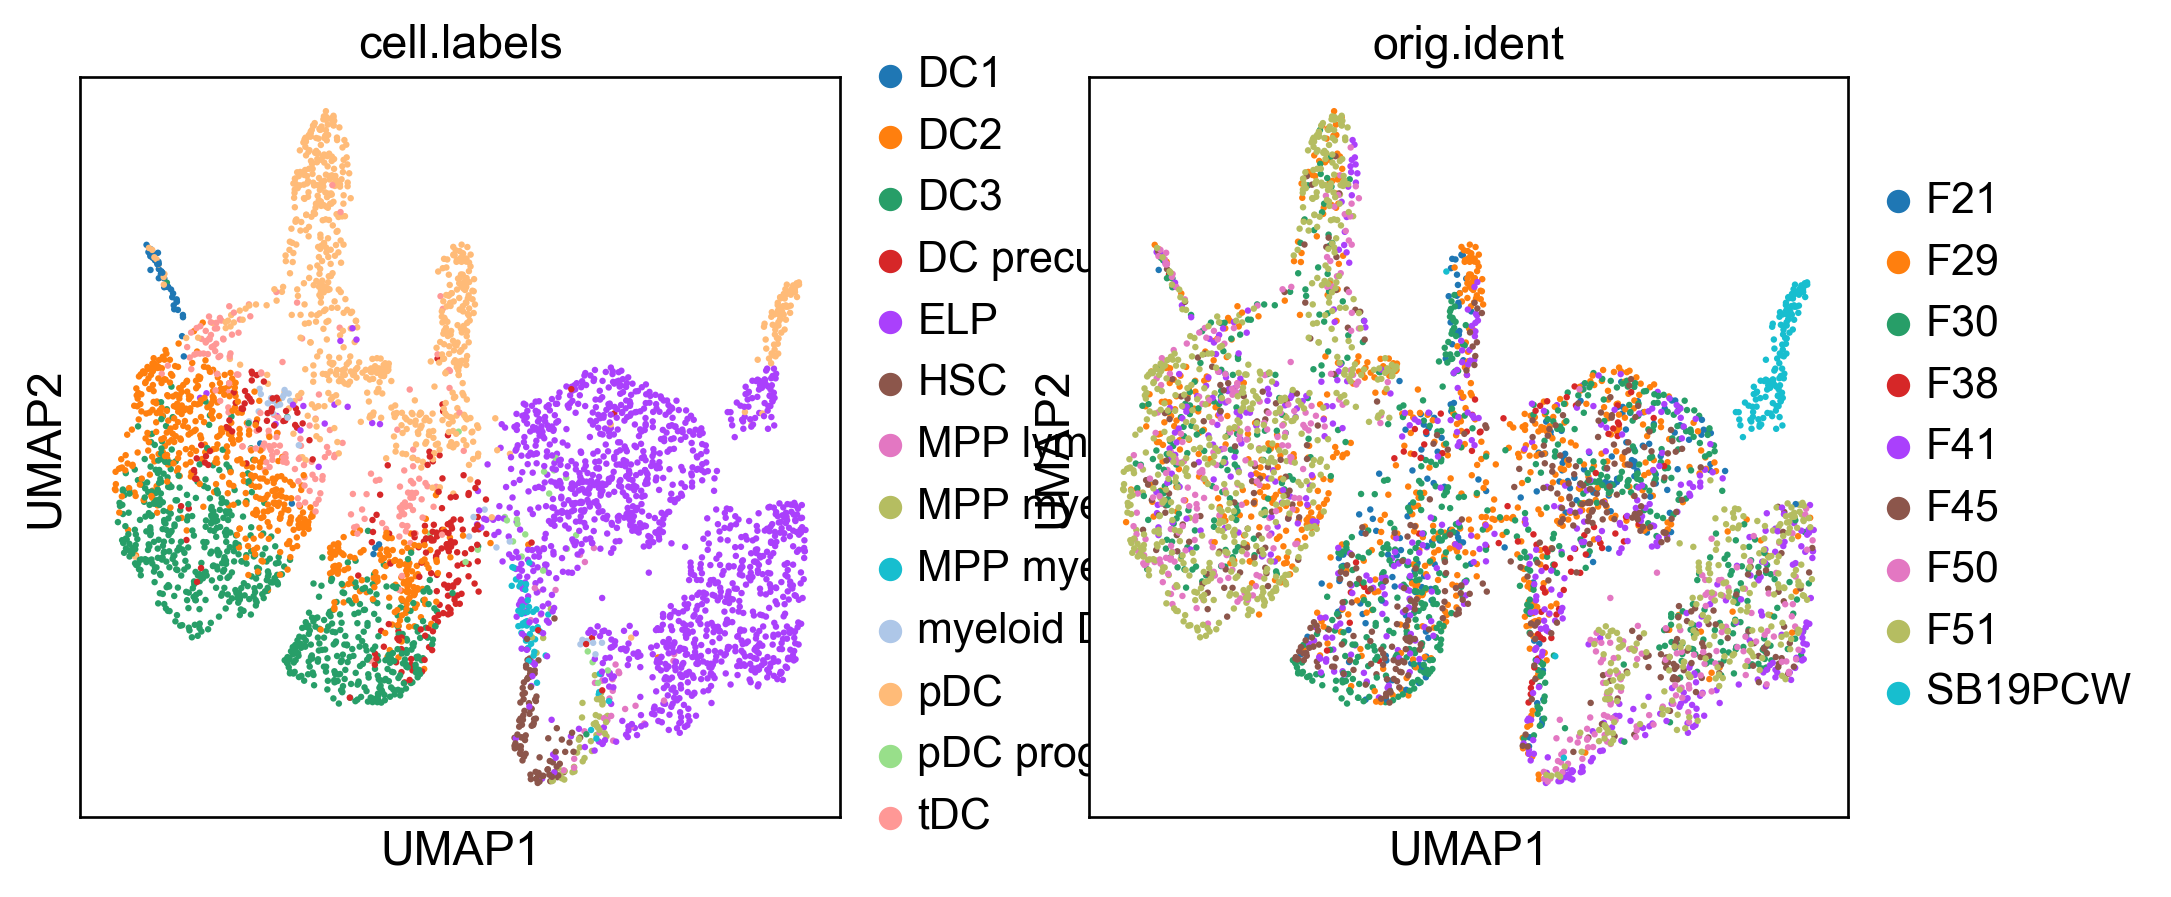

In [19]:
sc.pl.umap(adata, color=['cell.labels', 'orig.ident'], size=15) 

# Run harmony batch correction

In [20]:
#harmony prep - save pca and batch (sample) metadata columns 
pca = adata.obsm['X_pca']
batch = adata.obs['sequencing.type']

In [21]:
# load up harmony in rpy2
%load_ext rpy2.ipython

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [22]:
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)

hem = HarmonyMatrix(pca, batch, theta=3, verbose=TRUE, do_pca=FALSE)
hem = data.frame(hem)

R[write to console]: Loading required package: Rcpp

R[write to console]: Harmony 1/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[

R[write to console]: Harmony 7/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write t

In [23]:
# save old pca values or orig.pca and save batch corrected pca results in anndata object as x_pca
adata.obsm['X_orig_pca'] = adata.obsm['X_pca']
adata.obsm['X_pca'] = hem.values

# Add dimensional reduction post-harmony

In [24]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=10) 

In [25]:
# run umap
sc.tl.umap(adata) 

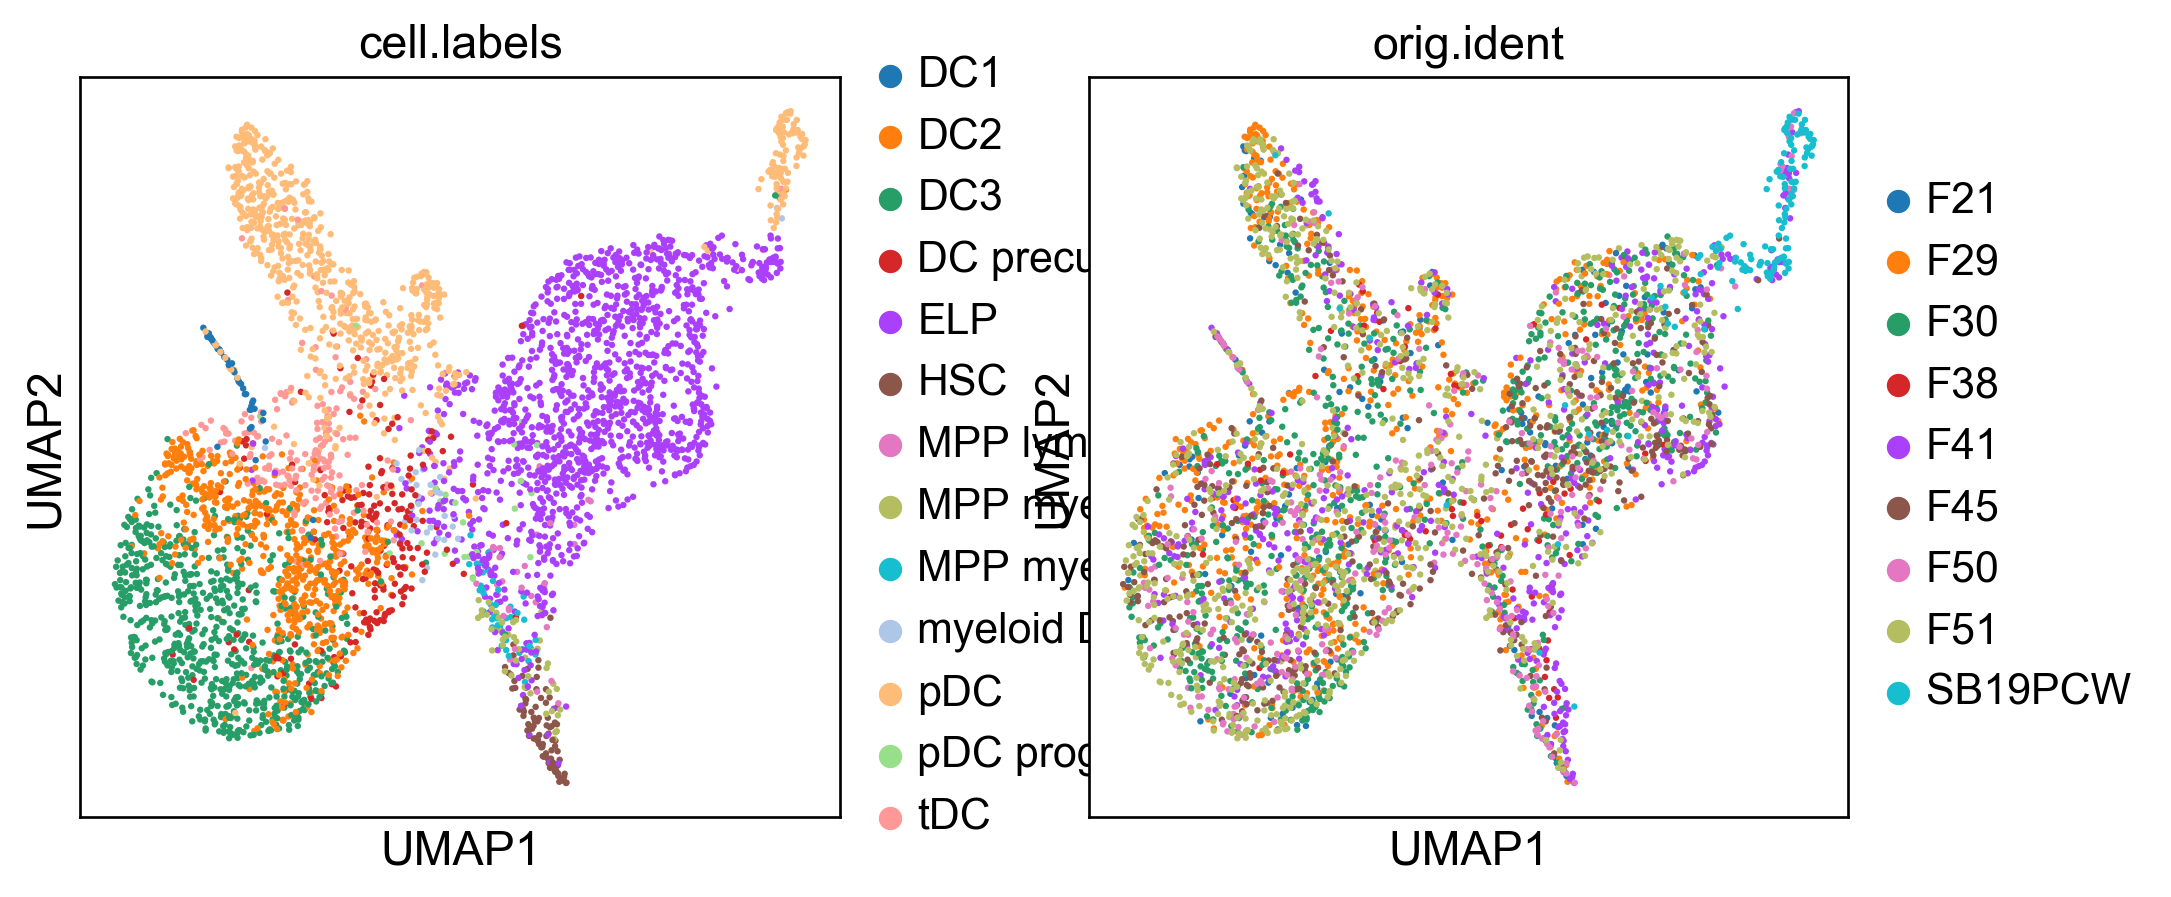

In [26]:
sc.pl.umap(adata, color=['cell.labels', 'orig.ident'], size=15) 

In [27]:
# run fdg 
# As an input, FDG requires PCA coordinates and a snn graph. must redo snn graph if re-running fdg on subsets 
sc.tl.draw_graph(adata, init_pos='X_pca', layout='fa')

# Change the colours for the gran and neut lineage

In [28]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"].cat.categories

Index(['DC1', 'DC2', 'DC3', 'DC precursor', 'ELP', 'HSC', 'MPP lymphoid',
       'MPP myeloid 1', 'MPP myeloid 2', 'myeloid DC progenitor', 'pDC',
       'pDC progenitor', 'tDC'],
      dtype='object')

In [29]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].cat.reorder_categories(['HSC', 'MPP myeloid 1', 'MPP myeloid 2', 
                'MPP lymphoid', 'ELP', 'pDC progenitor', 'pDC', 'tDC', 'myeloid DC progenitor', 'DC precursor', 
                'DC1', 'DC2', 'DC3'])

In [30]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"].cat.categories

Index(['HSC', 'MPP myeloid 1', 'MPP myeloid 2', 'MPP lymphoid', 'ELP',
       'pDC progenitor', 'pDC', 'tDC', 'myeloid DC progenitor', 'DC precursor',
       'DC1', 'DC2', 'DC3'],
      dtype='object')

In [31]:
adata.obs["cell.labels"].cat.categories[2]

'MPP myeloid 2'

In [32]:
new_colors = np.array(adata.uns["cell.labels_colors"])

new_colors[[0]] = '#d200d2' # HSC
new_colors[[1]] = '#0000ff' # MPP myeloid 1
new_colors[[2]] = '#0000ff' # MPP myeloid 2
new_colors[[3]] = '#7b7bff' # MPP lymphoid
new_colors[[4]] = '#cbcbff' # ELP
new_colors[[5]] = '#005300' # pDC progenitor
new_colors[[6]] = '#00a500'# pDC
new_colors[[7]] = '#73ff73' # tDC
new_colors[[8]] = '#a56900' # myeloid DC progenitor
new_colors[[9]] = '#c30000' # DC precursor
new_colors[[10]] = '#ff1616' # DC1
new_colors[[11]] = '#ff9191' # DC2
new_colors[[12]] = '#ffcdcd'# DC3

adata.uns["cell.labels_colors"] = new_colors

new_colors

array(['#d200d2', '#0000ff', '#0000ff', '#7b7bff', '#cbcbff', '#005300',
       '#00a500', '#73ff73', '#a56900', '#c30000', '#ff1616', '#ff9191',
       '#ffcdcd'], dtype='<U7')

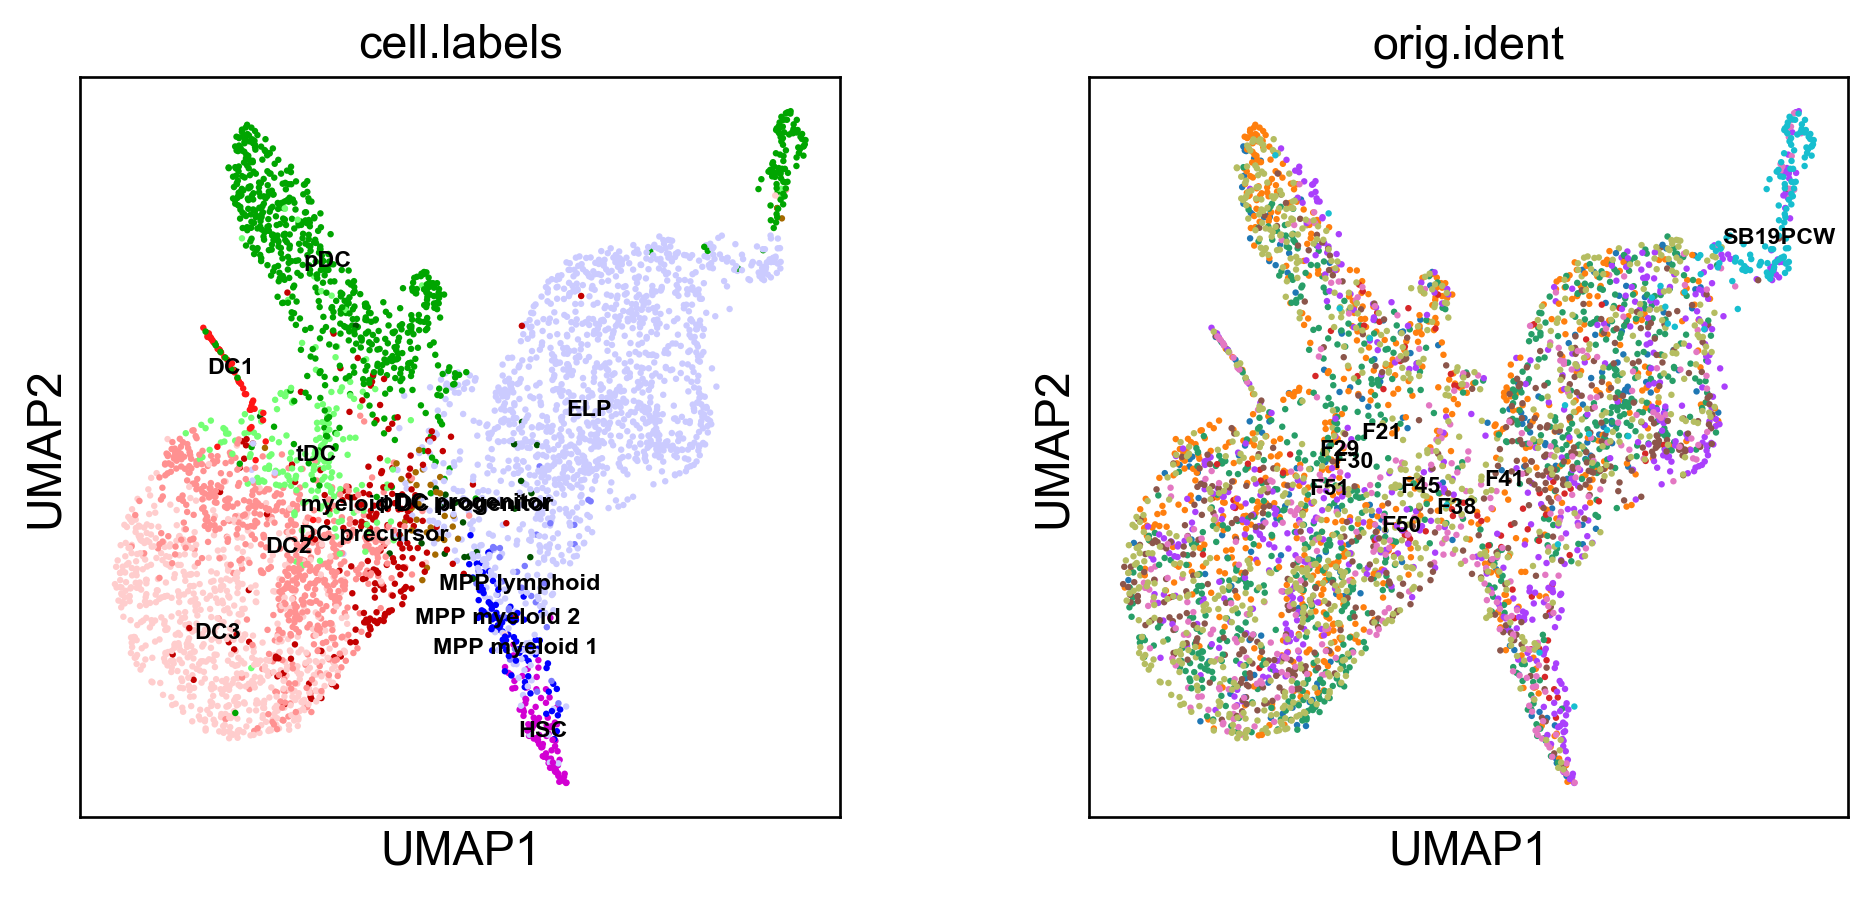

In [33]:
sc.pl.umap(adata, color=['cell.labels', 'orig.ident'], size=15, legend_loc="on data", legend_fontsize=7) 

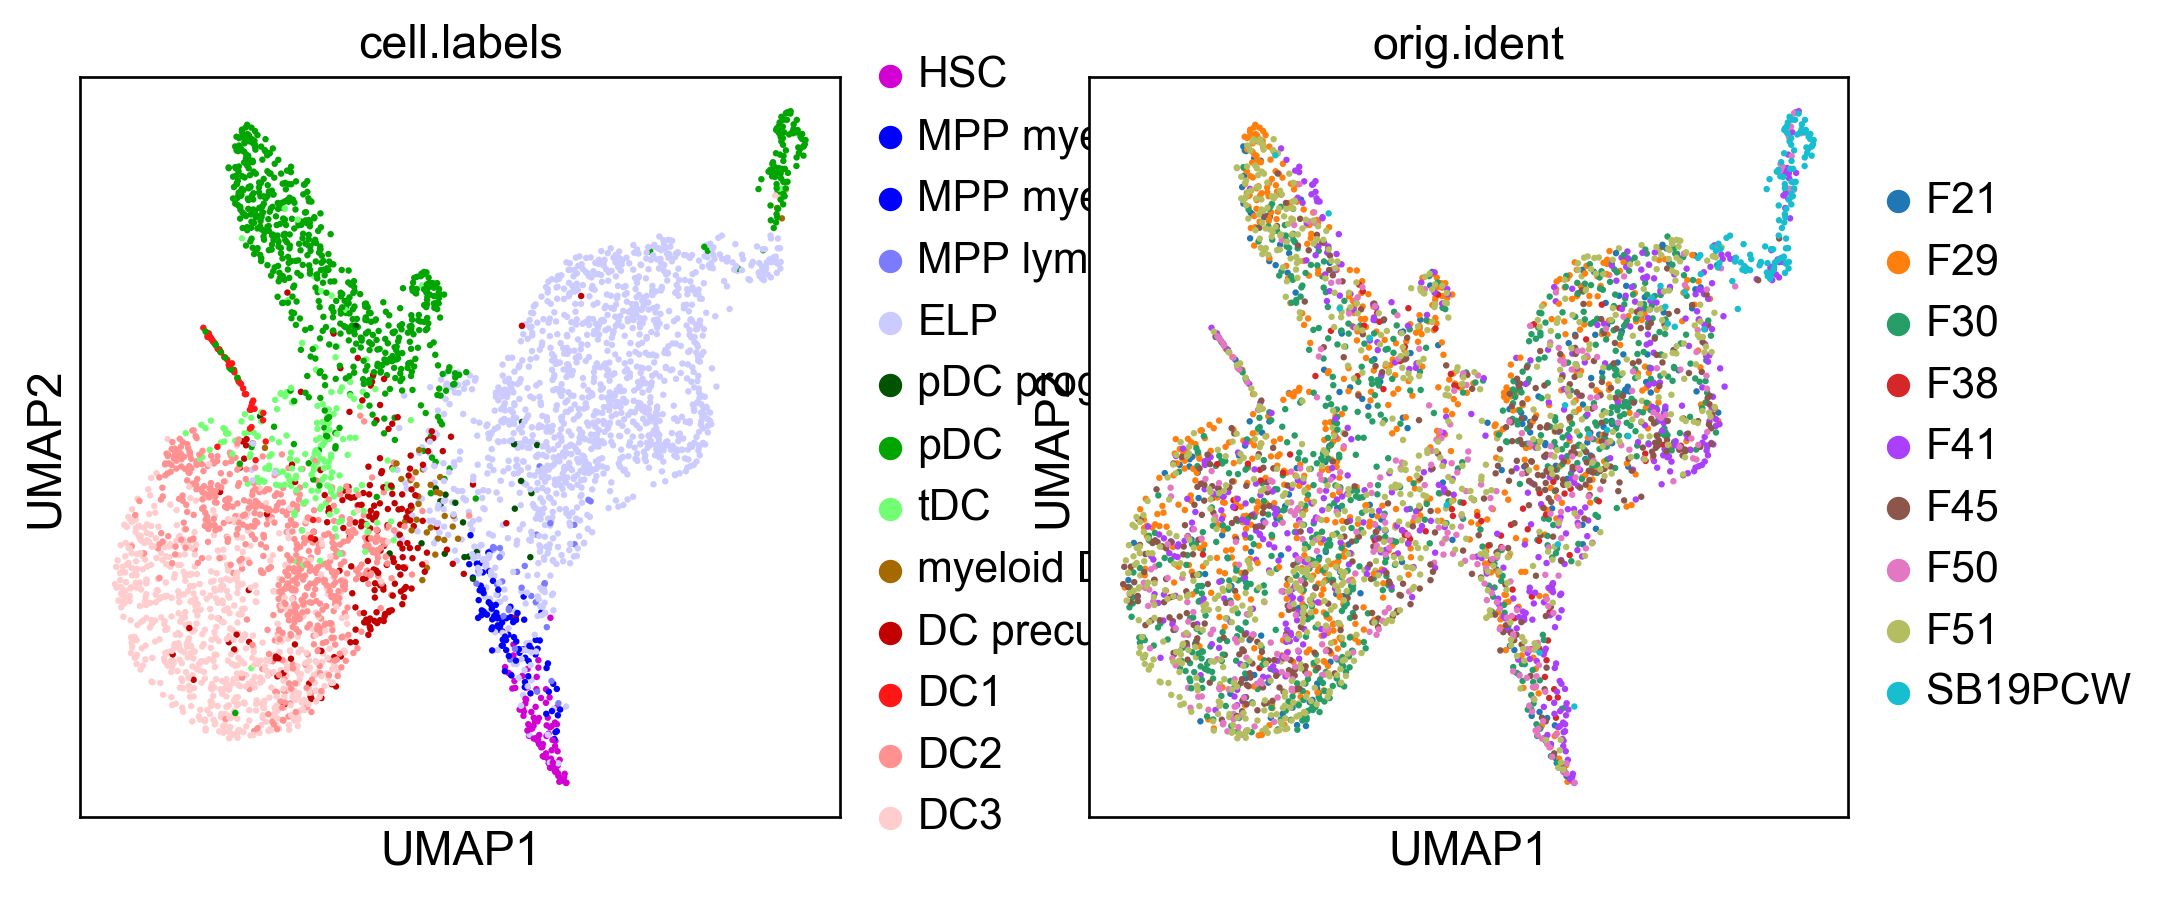

In [34]:
sc.pl.umap(adata, color=['cell.labels', 'orig.ident'], size=15) 

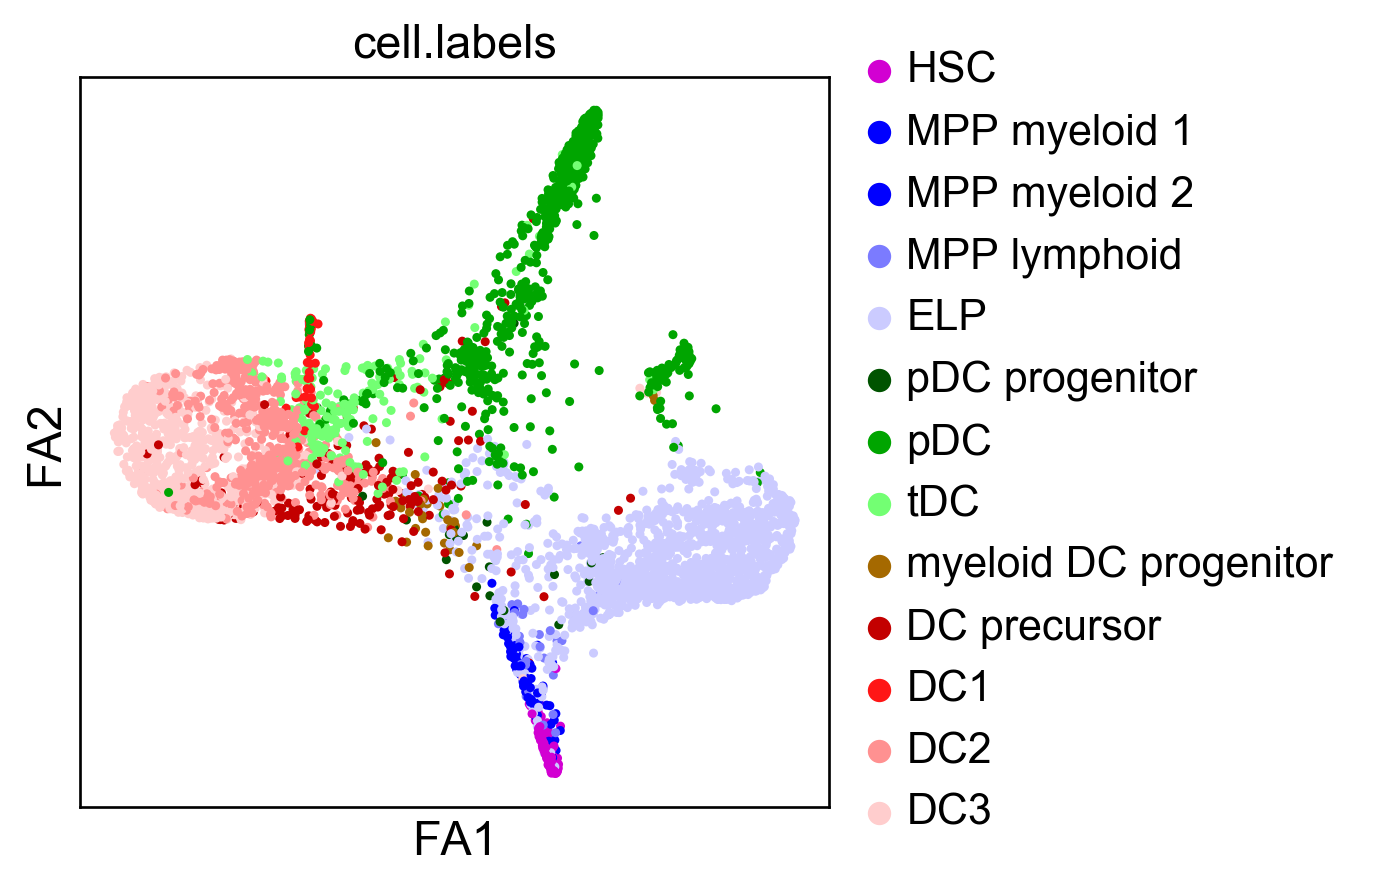

In [35]:
sc.pl.draw_graph(adata, color='cell.labels', layout='fa') #  show=False, save='_myeloid_pre-harmony_cell_labels_legoff.pdf'

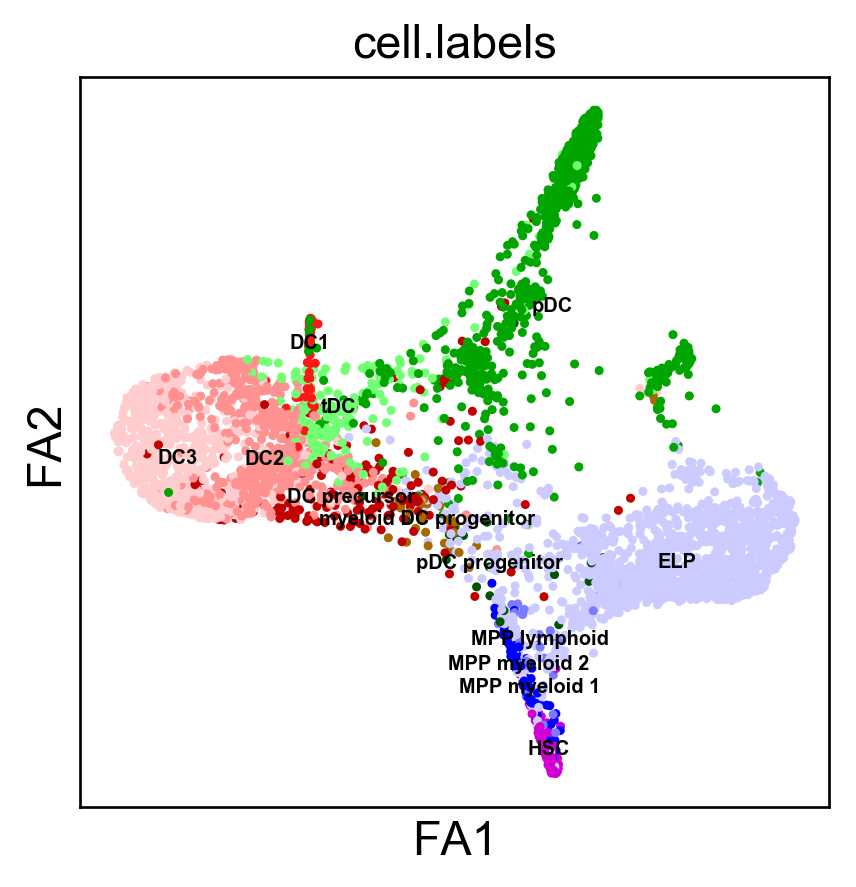

In [36]:
sc.pl.draw_graph(adata, color='cell.labels', legend_loc='on data', legend_fontsize=6) #  show=False, save='_myeloid_pre-harmony_cell_labels_legon.pdf', 

# Save plots

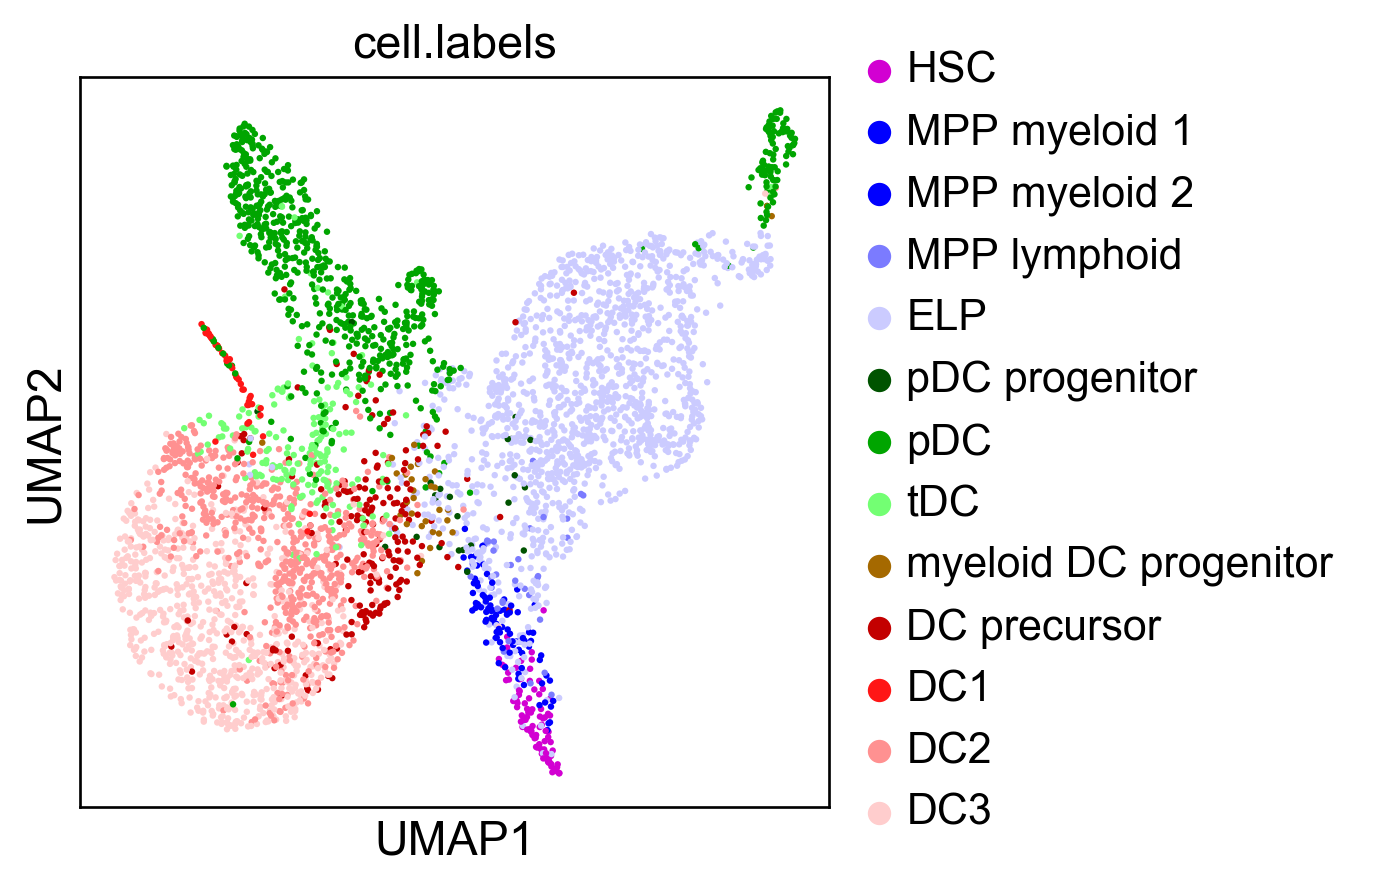

In [37]:
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.pl.umap(adata, color=['cell.labels'], size=15, save="fig2c_myeloid_dc_umap_20200416.pdf") 

In [38]:
sc.pl.draw_graph(adata, color='cell.labels', layout='fa', show=False, save='_fig2c_myeloid_dc_fdg_20200416.pdf')

# Save the data

In [39]:
from scipy.sparse import csr_matrix
adata.X = sparse.csr_matrix(adata.X)

In [40]:
adata.X

<4090x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 12833630 stored elements in Compressed Sparse Row format>

In [41]:
adata.raw.X

<4090x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 14890834 stored elements in Compressed Sparse Row format>

In [42]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/fig2c_myeloid_dc_dr_20200416.h5ad")

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
# silence NumbaPerformanceWarning
import warnings
from numba.errors import NumbaPerformanceWarning
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==0.23.4 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [3]:
adata = sc.read("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/fig2c_myeloid_dc_dr_20200416.h5ad")

In [4]:
genes = ['BCL7A',
'CD72',
'IGHV5-78',
'GZMB',
'JCHAIN',
'LILRA4',
'CYP46A1',
'TMEM107',
'VEGFB',
'TYROBP',
'IRF8',
'MPEG1',
'MCOLN2',
'GAS6',
'SCAMP4']

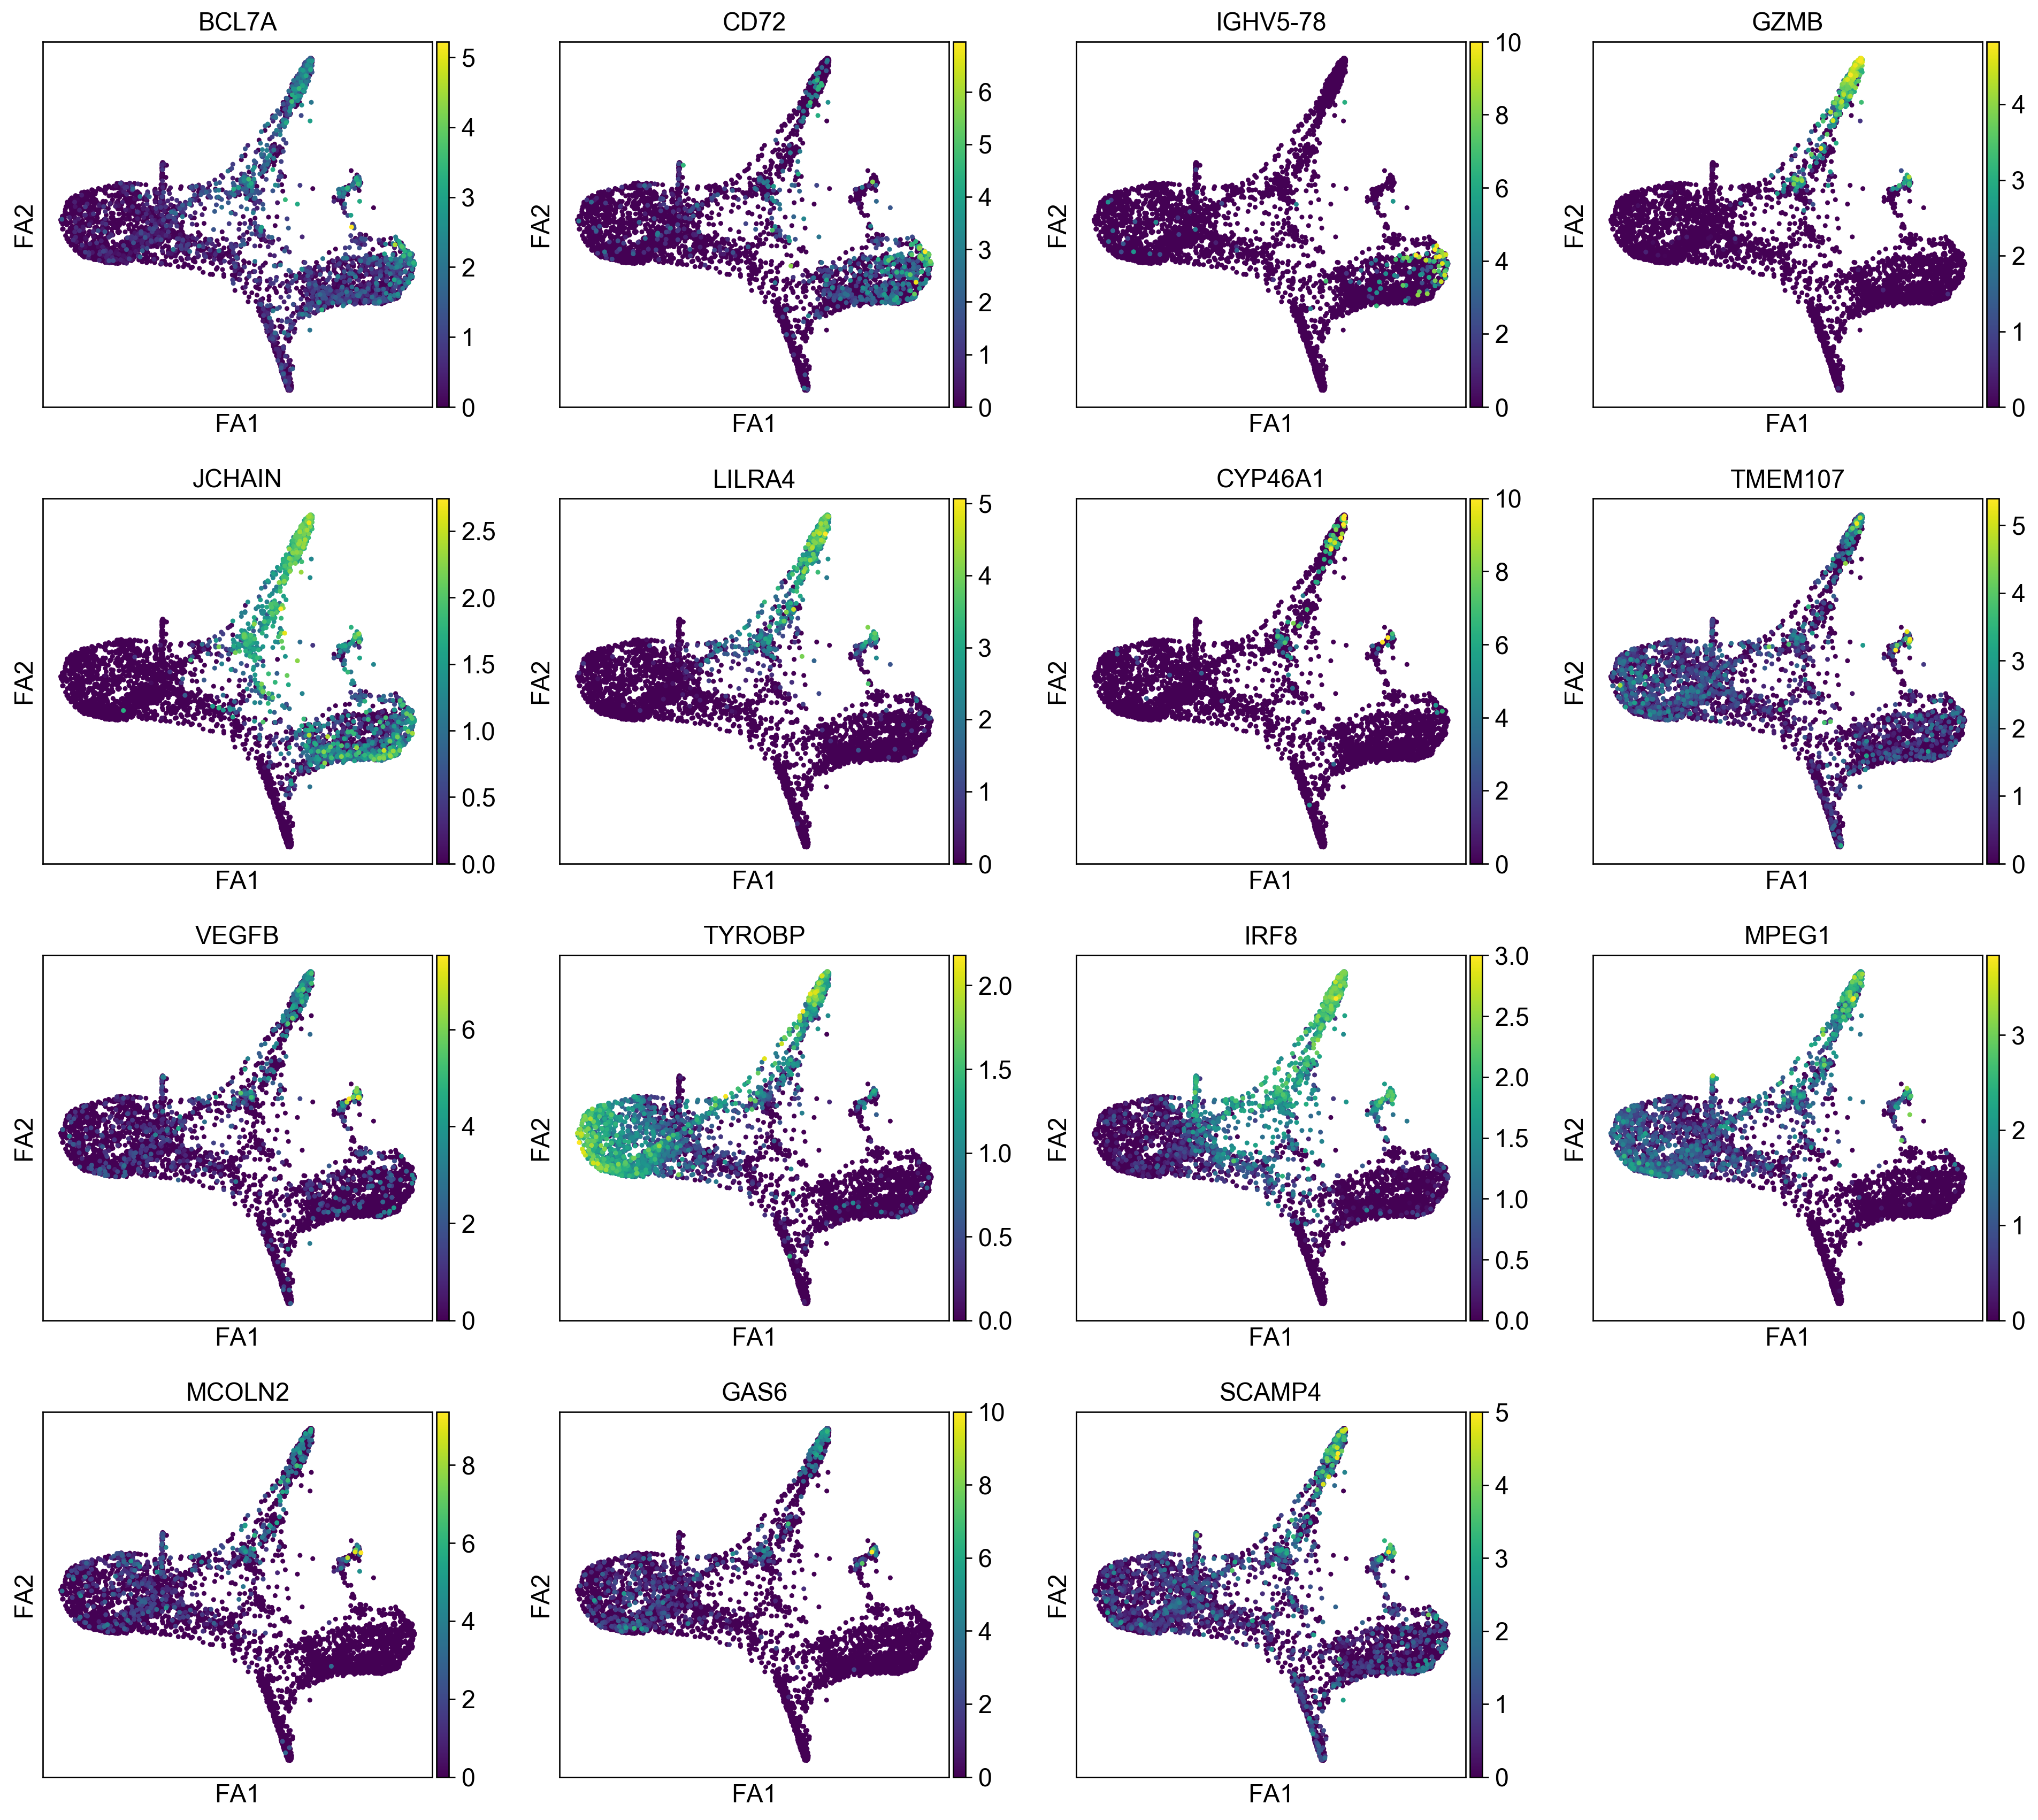

In [6]:
sc.pl.draw_graph(adata, color=genes, layout='fa', use_raw=False)